In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../python')
import os
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as tt
import torch.backends.cudnn as cudnn
import torch.nn as nn


import pickle

from tqdm import tqdm

from torchinfo import summary



from models import ResNet18
from functions import *
from Optimizers import PAdam

import time


import matplotlib.pyplot as plt
import numpy as np


In [2]:
# load device and model

device = get_default_device()
print(f'Device used: {device}')

model=to_device(ResNet18(3, 10), device)

num_params=sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params:,}")

device

Device used: cuda
Number of trainable parameters: 12,562,698


In [ ]:
# define transformation/augmentation
data_path = '../data'
mean_std_file = os.path.join(data_path, 'cifar10_mean_std.pkl')


# Check if mean/std file exists, calculate if not
if not os.path.exists(mean_std_file):
    # Load CIFAR-10 without normalization
    trainset_raw = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=tt.ToTensor())
    mean, std = calculate_mean_std(trainset_raw)
    with open(mean_std_file, 'wb') as f:
        pickle.dump((mean, std), f)
    print("Mean and Std Dev calculated and saved.")
else:
    with open(mean_std_file, 'rb') as f:
        mean, std = pickle.load(f)
    print("Mean and Std Dev loaded from file.")

print(f"Mean: {mean}, Std: {std}")

transform_train = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 

                         tt.RandomRotation(degrees=(-10, 10)),
                         tt.RandomHorizontalFlip(), 
                         #tt.RandomPerspective(distortion_scale=0.14),
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
                         tt.ToTensor(), 
                         tt.Normalize(mean,std,inplace=True)])
transform_test = tt.Compose([tt.ToTensor(), tt.Normalize(mean, std)])

In [ ]:
batch_size=400

# Load the CIFAR-10 dataset with transforms above
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3,pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=2*batch_size, shuffle=False, num_workers=3,pin_memory=True)


# move to device
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)

In [ ]:
epochs = 50
max_lr = 0.001
grad_clip = 0.75
weight_decay = 0.0001
betas=(0.9,0.95)

In [ ]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr,weight_decay=weight_decay,fused=True, betas=betas)
optimizer = PAdam(model.parameters(), lr=max_lr, lambda_p=5e-4, p_norm=0.8, betas=betas, fused=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
#                                         T_0 = 1563,# Number of iterations for the first restart (Total iterations are epochs*len(train_loader) then divide that by how many times you want a restart)
#                                         T_mult = 1, # A factor increases TiTi​ after a restart
#                                         eta_min = 1e-5) # Minimum learning rate
lr_int=5e-5
lr_fin=5e-5
div_factor=max_lr/lr_int
final_div_factor=lr_int/lr_fin
scheduler = torch.optim.lr_scheduler.OneCycleLR(
                                                optimizer, 
                                                max_lr, 
                                                epochs=epochs,
                                                steps_per_epoch=len(trainloader), 
                                                pct_start=0.1,
#                                                 div_factor=div_factor,
                                                final_div_factor=1e-4
                                            )


# Visualize scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
                                                optimizer, 
                                                max_lr, 
                                                epochs=epochs,
                                                steps_per_epoch=len(trainloader), 
                                                pct_start=0.1,
                                                div_factor=div_factor,
                                                final_div_factor=final_div_factor
                                            )
l_t=len(trainloader)
lrs=[]
for epoch in range(epochs):
        for d in range(l_t):
            lrs.append(optimizer.param_groups[0]['lr'])
            scheduler.step()
            

print(lrs[0],lrs[-1],max(lrs))
plt.semilogy(lrs)
plt.show()

In [ ]:
# model = torch.compile(model) # requires PyTorch 2.0



best_accuracy = 0.0
iteration_count = 0
train_losses = []
val_losses = []
accuracies = []
lrs = []

start_time = time.time()    
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for data in trainloader:
        iteration_count += 1
        inputs, labels = data

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        running_loss += loss.item()
        scheduler.step()

    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    running_val_loss = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            



    avg_val_loss = running_val_loss / len(testloader)
    val_losses.append(avg_val_loss)

    accuracy = 100 * correct / total
    accuracies.append(accuracy)

    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': accuracy,
        }, '../data/best_model.pth')

    # Calculate and format runtime and expected time
    elapsed_time = time.time() - start_time
    expected_time = elapsed_time * epochs / (epoch + 1)
    elapsed_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    expected_str = time.strftime("%H:%M:%S", time.gmtime(expected_time))

    # Track and store current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)

    status_message = f"Epoch: {epoch+1}/{epochs}\titer: {iteration_count}\tTrain Loss: {avg_train_loss:.4f}\tTest Loss: {avg_val_loss:.4f}\tAccuracy: {accuracy:.2f}%\tCurrent LR: {current_lr:.5f}\tElapsed Time: {elapsed_str}\tExpected Time: {expected_str}"
    print(f"\r{status_message}",end='')

print()
print('Finished Training')

5.0000008772981645e-05


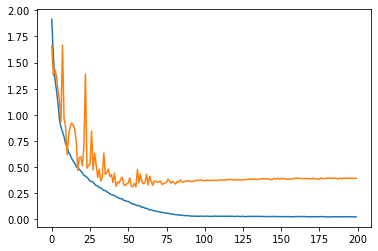

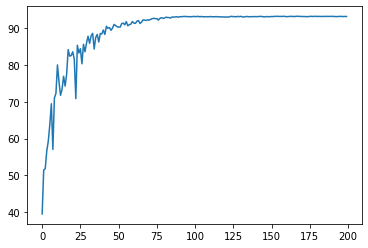

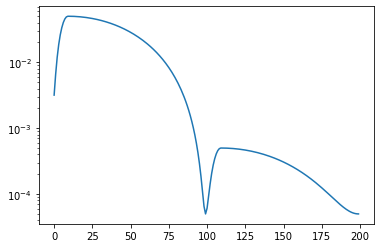

In [13]:

print(lrs[-1])

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

plt.plot(accuracies)
plt.show()

plt.semilogy(lrs)
plt.show()


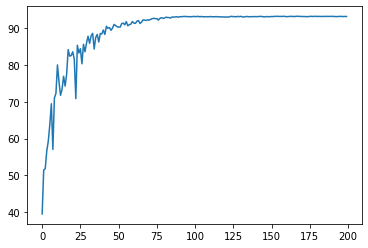

In [14]:
plt.plot(accuracies)
plt.show()

In [16]:
# Load the saved model
checkpoint = torch.load('../data/best_model.pth')
model_state_dict = checkpoint['model_state_dict']

# Iterate over each layer in the model
zeros=0
for layer_name, weights in model_state_dict.items():
    # Ensure you're looking at layer weights, not biases
    if "weight" in layer_name:
        # Convert the weights to a numpy array
        weights = weights.cpu().numpy()

        # Apply log10 to the absolute values of weights, with a small offset to avoid log(0)
        log_weights = np.log10(np.abs(weights) + 1e-13)
        zeros+=np.sum(log_weights<-12.5)
        

        # Plot histogram
        plt.hist(log_weights.reshape(-1), bins=50)
        plt.title(f"Histogram for log10(abs(weights)) in layer: {layer_name}")
        plt.xlabel("Log10 of Absolute Weight values")
        plt.ylabel("Frequency")
        plt.show()
        
zeros/num_params


AttributeError: 'ResNet18' object has no attribute 'items'

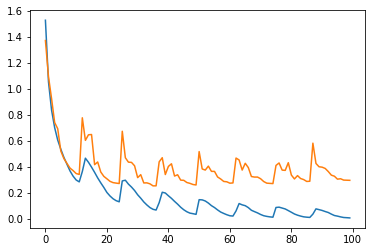

In [8]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()